### **Import Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Import Library**

In [2]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)
from sklearn.preprocessing import LabelEncoder
import cv2
import tensorflow as tf
import keras
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Load Data**

In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/DATA RD/')
Train = glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/DATASETS/Data Split/Train/*')
Val=glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/DATASETS/Data Split/Validation/*')
Test=glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/DATASETS/Data Split/Test/*')

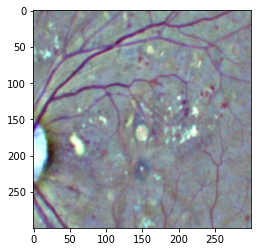

In [4]:
import matplotlib.image as mpimg
for ima in Train[600:601]:
     img=mpimg.imread(ima)
     imgplot = plt.imshow(img)
     plt.show()

### **Data Preparation**

In [0]:
nrows = 224
ncolumns = 224
channels = 3  

def read_and_process_image(list_of_images):
    
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels
        if 'Normal' in image:
            y.append(0)
        elif 'Mild' in image:
            y.append(1)
        elif 'Moderate' in image:
            y.append(2)
        elif 'Severe' in image:
            y.append(3)

    
    return X, y

In [0]:
X_train, y_train = read_and_process_image(Train)
X_val, y_val = read_and_process_image(Val)
X_test, y_test = read_and_process_image(Test)

In [7]:
import seaborn as sns
import gc 
gc.collect()

#Convert list to numpy array
X_train = np.array(X_train)
y_train= np.array(y_train)

X_val = np.array(X_val)
y_val= np.array(y_val)

X_test = np.array(X_test)
y_test= np.array(y_test)

print('Train:',X_train.shape,y_train.shape)
print('Val:',X_val.shape,y_val.shape)
print('Test',X_test.shape,y_test.shape)

Train: (6000, 224, 224, 3) (6000,)
Val: (1500, 224, 224, 3) (1500,)
Test (500, 224, 224, 3) (500,)


Text(0.5, 1.0, 'Total Data Training')

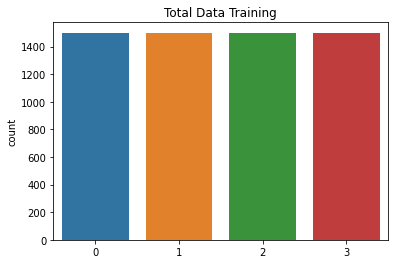

In [8]:
sns.countplot(y_train)
plt.title('Total Data Training')

Text(0.5, 1.0, 'Total Data Validasi')

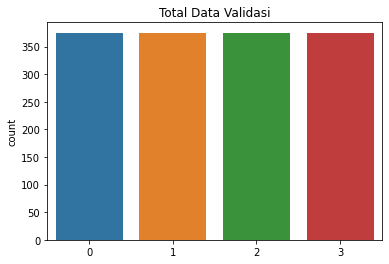

In [9]:
sns.countplot(y_val)
plt.title('Total Data Validasi')

Text(0.5, 1.0, 'Total Data Test')

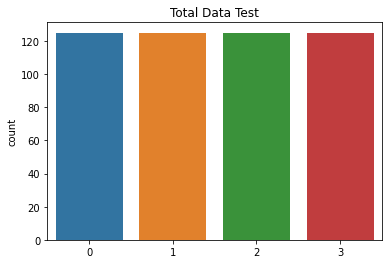

In [10]:
sns.countplot(y_test)
plt.title('Total Data Test')

In [11]:
y_train_ohe = pd.get_dummies(y_train)
y_val_ohe=pd.get_dummies(y_val)
y_test_ohe=pd.get_dummies(y_test)

y_train_ohe.shape,y_val_ohe.shape,y_test_ohe.shape

((6000, 4), (1500, 4), (500, 4))

### **Model Parameters**

In [0]:
batch_size = 16
EPOCHS = 100
WARMUP_EPOCHS = 2
LEARNING_RATE = 0.001
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

### **Data Generator**

In [0]:
train_datagen =tf.keras.preprocessing.image.ImageDataGenerator(
                                  rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True)

test_datagen=tf.keras.preprocessing.image.ImageDataGenerator()

In [0]:
train_generator = train_datagen.flow(X_train, y_train_ohe, batch_size=batch_size)
val_generator = test_datagen.flow(X_val, y_val_ohe, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test_ohe, batch_size=batch_size)

### **Define Model**

In [0]:
IMG_SHAPE = (224, 224, 3)
base_model =tf.keras.applications.InceptionV3(weights='imagenet', 
                                       include_top=False,
                                       input_shape=IMG_SHAPE)
x =tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x =tf.keras.layers.Dropout(0.15)(x)
x =tf.keras.layers.Dense(1024, activation='relu')(x)
x =tf.keras.layers.Dropout(0.15)(x)
final_output =tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='final_output')(x)
model =tf.keras.models.Model(inputs=base_model.inputs,outputs=final_output)

### **Train Top Layers**

In [16]:
for layer in model.layers: 
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer =tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
import time

start = time.time()

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=val_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

end = time.time()
print('Waktu Training:', end - start)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
375/375 [==============================] - 58s 155ms/step - loss: 4.9675 - accuracy: 0.4495 - val_loss: 1.0770 - val_accuracy: 0.5249
Epoch 2/2
375/375 [==============================] - 57s 152ms/step - loss: 1.1431 - accuracy: 0.4808 - val_loss: 1.0855 - val_accuracy: 0.4745
Waktu Training: 120.56480002403259


### **Train Fine Tuning**

In [18]:
for layer in model.layers:
  layer.trainable = True

es =tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es]
optimizer =tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=val_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/100
375/375 [==============================] - 61s 162ms/step - loss: 0.9995 - accuracy: 0.5755 - val_loss: 2.9049 - val_accuracy: 0.2097
Epoch 2/100
375/375 [==============================] - 60s 160ms/step - loss: 0.7692 - accuracy: 0.6845 - val_loss: 1.3373 - val_accuracy: 0.4940
Epoch 3/100
375/375 [==============================] - 60s 160ms/step - loss: 0.6431 - accuracy: 0.7388 - val_loss: 1.2615 - val_accuracy: 0.6008
Epoch 4/100
375/375 [==============================] - 60s 160ms/step - loss: 0.5968 - accuracy: 0.7527 - val_loss: 0.7731 - val_accuracy: 0.6505
Epoch 5/100
375/375 [==============================] - 60s 159ms/step - loss: 0.5510 - accuracy: 0.7790 - val_loss: 0.6895 - val_accuracy: 0.7325
Epoch 7/100
375/375 [==============================] - 59s 159ms/step - loss: 0.5290 - accuracy: 0.7852 - val_loss: 0.5902 - val_accuracy: 0.7728
Epoch 8/100
375/375 [==============================] - 60s 160ms/step - loss: 0.5166 - accuracy: 0.7862 - val_loss: 0.7532 -

### **Model Graph**

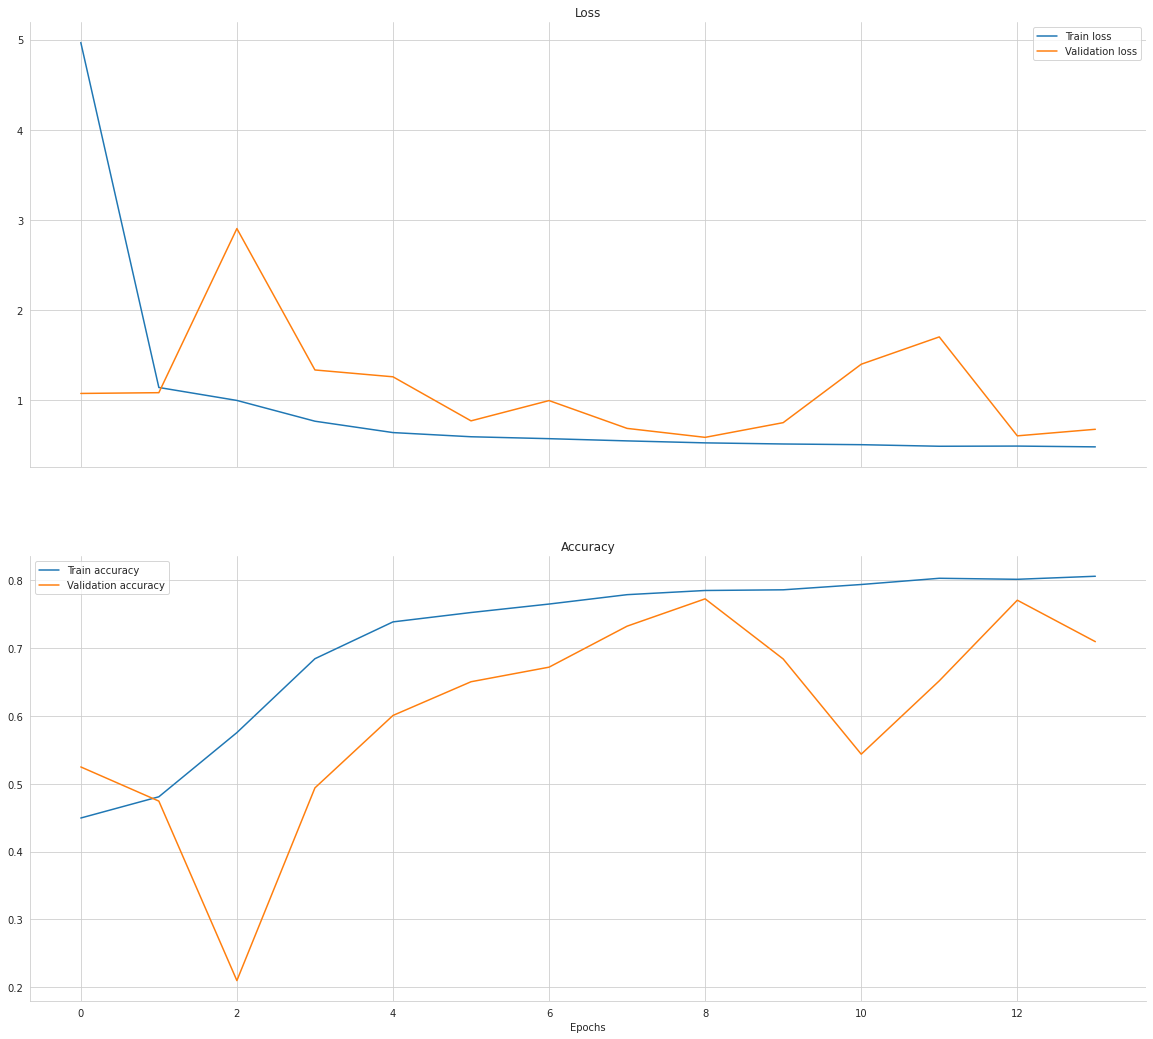

In [20]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['accuracy'] + history_finetunning['accuracy'], 
           'val_acc': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 18))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

### **Evaluate Model**

In [21]:
loss_Val, acc_Val = model.evaluate(X_val, y_val_ohe,batch_size=1, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_Val, loss_Val))

1500/1500 [==============================] - 21s 14ms/step - loss: 0.5946 - accuracy: 0.7713
Validation: accuracy = 0.771333  ;  loss_v = 0.594641


In [0]:
lastFullTrainPred = np.empty((0, N_CLASSES))
lastFullTrainLabels = np.empty((0, N_CLASSES))
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

for i in range(STEP_SIZE_TRAIN+1):
    im, lbl = next(train_generator)
    scores = model.predict(im, batch_size=train_generator.batch_size)
    lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
    lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(val_generator)
    scores = model.predict(im, batch_size=val_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)

In [0]:
lastFullComPred = np.concatenate((lastFullTrainPred, lastFullValPred))
lastFullComLabels = np.concatenate((lastFullTrainLabels, lastFullValLabels))
complete_labels = [np.argmax(label) for label in lastFullComLabels]

train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
train_labels = [np.argmax(label) for label in lastFullTrainLabels]
validation_preds = [np.argmax(pred) for pred in lastFullValPred]
validation_labels = [np.argmax(label) for label in lastFullValLabels]

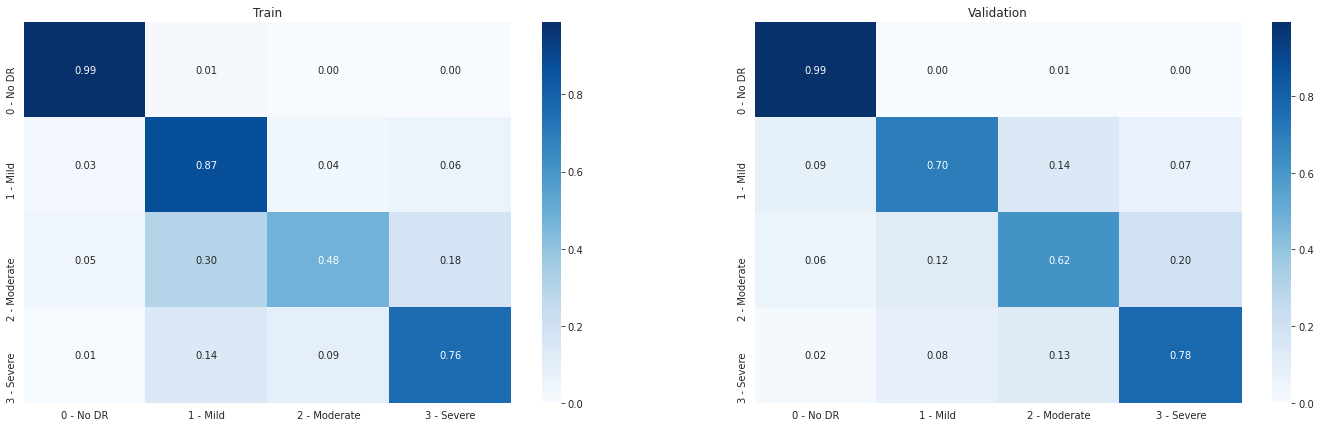

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe']
train_cnf_matrix = confusion_matrix(train_labels, train_preds)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax2).set_title('Validation')
plt.show()